In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error

2025-05-30 10:21:47.907712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)]  # MB
        )
        print("VRAM limited to 100 MB.")
    except RuntimeError as e:
        print("Memory configuration must be set at program start:", e)


VRAM limited to 100 MB.


2025-05-30 10:21:49.603554: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-30 10:21:52.100394: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-30 10:21:52.100474: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    
    # Drop last 6 rows
    df = df.iloc[:-6]
    
    # Convert date column to datetime
    df['#date+time'] = pd.to_datetime(df['#date+time'], errors='coerce')
    df = df.rename(columns={'#date+time': 'date_time'})
    
    # Convert all other columns to numeric
    for col in df.columns:
        if col != 'date_time':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df
def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)
    # This converts FROM meteorological TO Cartesian
    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

def prepare_dataframe(df):
    # Rename columns to a consistent format
    df = df.rename(columns={
        df.columns[0]: 'date_time',
        df.columns[1]: 'pwl',
        df.columns[2]: 'wsd',
        df.columns[3]: 'wdr'
    })
    
    # Convert wind to U/V components
    u, v = wind_to_uv(df['wsd'], df['wdr'])
    df[['u', 'v']] = np.column_stack((u, v))
    
    # Drop raw wind columns
    df.drop(columns=['wsd', 'wdr'], inplace=True)
    
    return df

def input_output_arrays(pl_df, po_df, wl_window, wind_window):

    wl_window = wl_window * 10
    wind_window = wind_window * 10

    pl_df = pl_df.reset_index(drop=True)
    po_df = po_df.reset_index(drop=True)

    pl_pwl = pl_df['pwl'].to_numpy()
    pl_u   = pl_df['u'].to_numpy()
    pl_v   = pl_df['v'].to_numpy()
    po_pwl = po_df['pwl'].to_numpy()

    X, y, indices = [], [], []

    for t in range(max(wl_window, wind_window), len(pl_df) - wl_window):
        # Water level window: centered at t
        wl_slice = slice(t - wl_window, t + wl_window + 1)

        # Wind window: past `wind_window` values ending at t
        wind_slice = slice(t - wind_window + 1, t + 1)

        pwl_input = pl_pwl[wl_slice]
        u_input = pl_u[wind_slice]
        v_input = pl_v[wind_slice]
        target = po_pwl[t]

        if (
            np.isnan(pwl_input).any() or
            np.isnan(u_input).any() or
            np.isnan(v_input).any() or
            np.isnan(target)
        ):
            continue

        features = np.concatenate([pwl_input, u_input, v_input])
        X.append(features)
        y.append(target)
        indices.append(t)

    return np.array(X), np.array(y), np.array(indices)

file_paths = {
    'po11': '/home/ryan/Downloads/po_2011-2012.csv',
    'pl11': '/home/ryan/Downloads/pl_2011-2012.csv',
    'po13': '/home/ryan/Downloads/po_2013-2014.csv',
    'pl13': '/home/ryan/Downloads/pl_2013-2014.csv',
    'po15': '/home/ryan/Downloads/po_2015-2016.csv',
    'pl15': '/home/ryan/Downloads/pl_2015-2016.csv',
}

def calculate_central_frequency_percentage(testing_label_array, predictions, cm):
  """Find the percentage of predictions with a central frequency (CF) of less than
  or equal to a given number of centimeters (cm)

	Args:
        testing_label_array (array): Testing labels

        predictions (array): Model predictions

        cm (int): Number of centimeters

	Returns:
		(float): central frequency (CF) percentage
	"""
  less_than_cm_counter = 0

  # Convert cm to m
  cm_to_m = cm / 100

  for index, prediction in enumerate(predictions):
    if abs(testing_label_array[index] - prediction) <= cm_to_m:
      less_than_cm_counter += 1

  cf_percentage = (less_than_cm_counter / len(predictions)) * 100

  return cf_percentage


def evaluate_model(model, testing_input_array, testing_label_array):
  """Calculates loss, makes predictions, and calculates Central Frequency (CF),
  Mean Squared Error (MSE), Root Mean Squared Error(RMSE), Mean Absolute Error (MAE),
  Median Absolute Error, and R-squared (R2)

	Args:
        model (tf.keras.model): The trained model

        testing_input_array (array): Testing inputs

        testing_label_array (array): Testing labels
	"""
  print("Calculating Loss:")
  test_loss = model.evaluate(testing_input_array, testing_label_array, batch_size = len(testing_input_array))

  print("Loss:", test_loss)


  print("\nGenerating output predictions with model:")
  predictions = model.predict(testing_input_array, batch_size = len(testing_input_array))

  # Calculate evaluation metrics
  cf_15cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 15)
  cf_5cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 5)
  cf_1cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 1)
  mse = mean_squared_error(testing_label_array, predictions)
  rmse = root_mean_squared_error(testing_label_array, predictions)
  mae = mean_absolute_error(testing_label_array, predictions)
  medae = median_absolute_error(testing_label_array, predictions)
  r2 = r2_score(testing_label_array, predictions)

  print("\nCentral Frequency Percentage 15cm:", cf_15cm_percentage)
  print("\nCentral Frequency Percentage 5cm:", cf_5cm_percentage)
  print("\nCentral Frequency Percentage 1cm:", cf_1cm_percentage)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("Mean Absolute Error:", mae)
  print("Median Absolute Error:", medae)
  print("R-squared:", r2)

datasets = {key: load_and_clean_csv(path) for key, path in file_paths.items()}

for name, df in datasets.items():
    datasets[name] = prepare_dataframe(df)


/tmp/ipykernel_1147417/2923689263.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_1147417/2923689263.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Each cell has different input sets for testing


2hr waterlevel inputs at 6min intervals and 2hr uv wind inputs at 6 min interval

(167924, 81) (167924,)
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 18.1060 - mae: 4.2377
Epoch 1: val_loss improved from inf to 16.78151, saving model to 2wl_2uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 18.1060 - mae: 4.2377 - val_loss: 16.7815 - val_mae: 4.0834
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 17.3596 - mae: 4.1516
Epoch 2: val_loss improved from 16.78151 to 16.06809, saving model to 2wl_2uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 17.3596 - mae: 4.1516 - val_loss: 16.0681 - val_mae: 3.9975
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 16.6027 - mae: 4.0621
Epoch 3: val_loss improved from 16.06809 to 15.36006, saving model to 2wl_2uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 16.6027 - mae: 4.0621 - val_loss: 15.3601 - val_mae: 3.9101
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 15.8544 - mae: 3.9712
Epoch 4: val_loss improved from 15.36006 to 14.66028, saving model to 2wl_2uv.keras
1/1 ━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 20)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,985 (19.48 KB)

 Trainable params: 1,661 (6.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,324 (12.99 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1163 - mae: 0.2687
Loss: [0.11626964807510376, 0.26872456073760986]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step

Central Frequency Percentage 15cm: 34.77965526025304

Central Frequency Percentage 5cm: 11.926848942854717

Central Frequency Percentage 1cm: 2.3637174153010103
Mean Squared Error: 0.1162696435512281
Root Mean Squared Error: 0.34098334790899704
Mean Absolute Error: 0.26872454322589984
Median Absolute Error: 0.22491043567657476
R-squared: -4.073342731164788


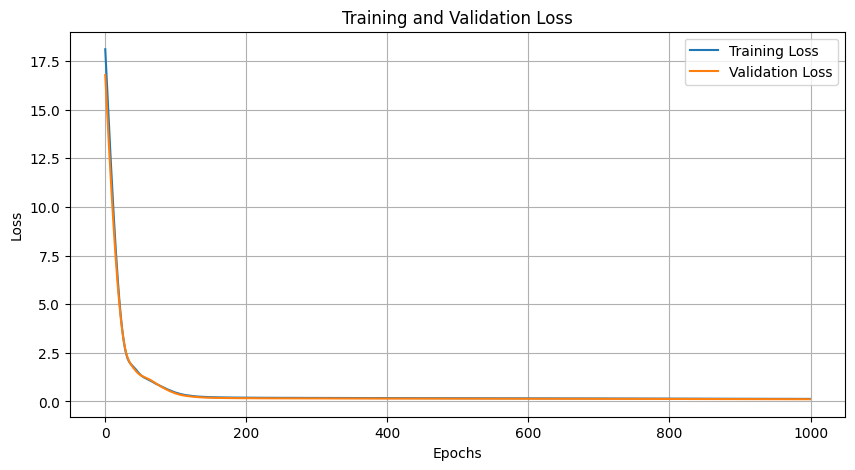

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


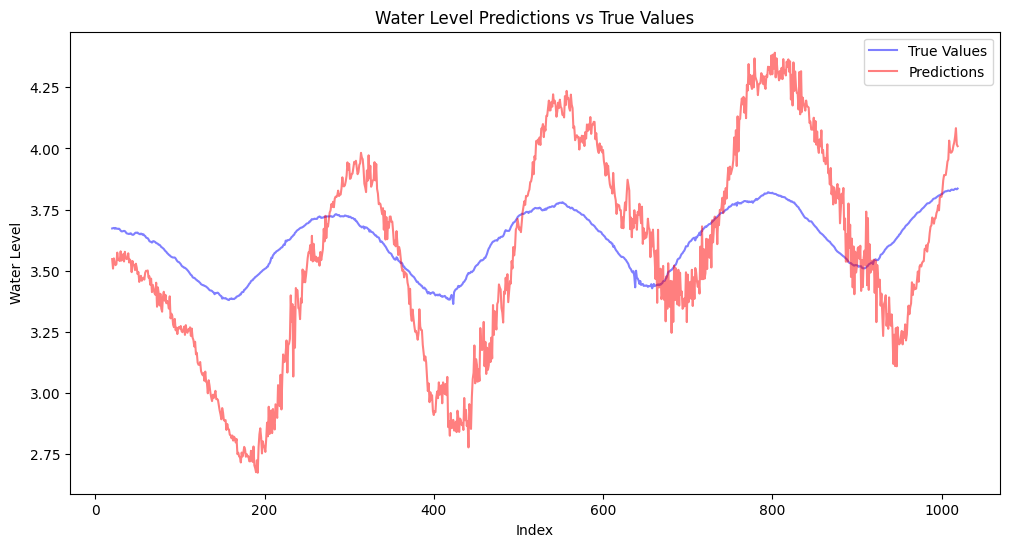

In [ ]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=2, wind_window=2)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=2, wind_window=2)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=2, wind_window=2)

print(X_train.shape, y_train.shape)

model_file_name = '2wl_2uv.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.02),
    #tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

Verification of inputoutput matching

In [4]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=2, wind_window=2)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=2, wind_window=2)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=2, wind_window=2)

In [5]:
print(X_train[0])
print(y_train[0])
print(indices_train[0])


[ 0.886       0.871       0.861       0.859       0.878       0.875
  0.867       0.885       0.885       0.881       0.884       0.886
  0.897       0.893       0.897       0.898       0.905       0.911
  0.908       0.915       0.916       0.92        0.924       0.928
  0.931       0.934       0.941       0.945       0.949       0.952
  0.954       0.959       0.964       0.969       0.973       0.975
  0.978       0.983       0.987       0.991       0.994      -5.48400774
 -5.5785596  -5.13570519 -5.76766331 -5.10580031 -5.32591649 -5.3830655
 -5.5785596  -5.54656758 -5.54656758 -5.01124845 -5.41476647 -5.13570519
 -5.5785596  -5.54656758 -5.76757018 -5.79555496 -5.57544132 -5.49711223
 -5.49711223  1.8882953   1.92085211  1.66869177  1.98596574  1.75806803
  1.73049517  1.54356919  1.92085211  1.69575589  1.69575589  1.72551122
  2.07853411  1.66869177  1.92085211  1.69575589  1.65382413  1.55291427
  1.18509664  1.06853037  1.06853037]
3.572
20


In [9]:
datasets['pl11'][0:41]

date_time    pwl         u         v
0  2011-11-01 00:00:00  0.886 -5.673111  1.953409
1  2011-11-01 00:06:00  0.871 -5.484008  1.888295
2  2011-11-01 00:12:00  0.861 -5.578560  1.920852
3  2011-11-01 00:18:00  0.859 -5.135705  1.668692
4  2011-11-01 00:24:00  0.878 -5.767663  1.985966
5  2011-11-01 00:30:00  0.875 -5.105800  1.758068
6  2011-11-01 00:36:00  0.867 -5.325916  1.730495
7  2011-11-01 00:42:00  0.885 -5.383065  1.543569
8  2011-11-01 00:48:00  0.885 -5.578560  1.920852
9  2011-11-01 00:54:00  0.881 -5.546568  1.695756
10 2011-11-01 01:00:00  0.884 -5.546568  1.695756
11 2011-11-01 01:06:00  0.886 -5.011248  1.725511
12 2011-11-01 01:12:00  0.897 -5.414766  2.078534
13 2011-11-01 01:18:00  0.893 -5.135705  1.668692
14 2011-11-01 01:24:00  0.897 -5.578560  1.920852
15 2011-11-01 01:30:00  0.898 -5.546568  1.695756
16 2011-11-01 01:36:00  0.905 -5.767570  1.653824
17 2011-11-01 01:42:00  0.911 -5.795555  1.552914
18 2011-11-01 01:48:00  0.908 -5.575441  1.185097
19 2011-11-01 01:54:00  0.915 -5.497112  1.068530
20 2011-11-01 02:00:00  0.916 -5.497112  1.068530
21 2011-11-01 02:06:00  0.920 -4.972785  1.520333
22 2011-11-01 02:12:00  0.924 -5.040600  1.637790
23 2011-11-01 02:18:00  0.928 -4.902435  1.405751
24 2011-11-01 02:24:00  0.931 -4.877154  1.491096
25 2011-11-01 02:30:00  0.934 -4.727593  1.627841
26 2011-11-01 02:36:00  0.941 -4.633041  1.595284
27 2011-11-01 02:42:00  0.945 -4.945494  1.606888
28 2011-11-01 02:48:00  0.949 -4.494632  1.374147
29 2011-11-01 02:54:00  0.952 -4.349385  1.497614
30 2011-11-01 03:00:00  0.954 -4.349385  1.497614
31 2011-11-01 03:06:00  0.959 -4.604494  1.675899
32 2011-11-01 03:12:00  0.964 -4.792432  1.744303
33 2011-11-01 03:18:00  0.969 -4.510525  1.641697
34 2011-11-01 03:24:00  0.973 -4.510525  1.641697
35 2011-11-01 03:30:00  0.975 -4.727593  1.627841
36 2011-11-01 03:36:00  0.978 -4.633041  1.595284
37 2011-11-01 03:42:00  0.983 -4.886402  1.778505
38 2011-11-01 03:48:00  0.987 -4.698463  1.710101
39 2011-11-01 03:54:00  0.991 -4.792432  1.744303
40 2011-11-01 04:00:00  0.994 -4.792432  1.744303

In [10]:
datasets['po11'][0:41]

date_time    pwl         u         v
0  2011-11-01 00:00:00  3.493 -4.414738  2.347358
1  2011-11-01 00:06:00  3.495 -4.792432  1.744303
2  2011-11-01 00:12:00  3.498 -4.673729  2.279530
3  2011-11-01 00:18:00  3.504 -4.633234  2.360751
4  2011-11-01 00:24:00  3.509 -4.633234  2.360751
5  2011-11-01 00:30:00  3.511 -4.455033  2.269952
6  2011-11-01 00:36:00  3.520 -4.583850  2.235693
7  2011-11-01 00:42:00  3.520 -4.722946  2.617972
8  2011-11-01 00:48:00  3.525 -4.811435  2.451549
9  2011-11-01 00:54:00  3.528 -4.659082  2.074357
10 2011-11-01 01:00:00  3.538 -4.659082  2.074357
11 2011-11-01 01:06:00  3.541 -4.070631  2.543612
12 2011-11-01 01:12:00  3.546 -4.589935  2.650000
13 2011-11-01 01:18:00  3.549 -4.326443  2.300411
14 2011-11-01 01:24:00  3.552 -4.635919  1.873033
15 2011-11-01 01:30:00  3.557 -4.841791  2.155704
16 2011-11-01 01:36:00  3.559 -4.543201  1.835572
17 2011-11-01 01:42:00  3.564 -4.591327  2.441252
18 2011-11-01 01:48:00  3.567 -4.169016  1.944044
19 2011-11-01 01:54:00  3.571 -4.443937  1.530170
20 2011-11-01 02:00:00  3.572 -4.443937  1.530170
21 2011-11-01 02:06:00  3.577 -4.763140  2.750000
22 2011-11-01 02:12:00  3.583 -4.622170  2.155353
23 2011-11-01 02:18:00  3.586 -4.635484  2.569491
24 2011-11-01 02:24:00  3.591 -4.679622  2.488199
25 2011-11-01 02:30:00  3.596 -4.633234  2.360751
26 2011-11-01 02:36:00  3.603 -4.494655  2.808572
27 2011-11-01 02:42:00  3.608 -4.749069  2.967548
28 2011-11-01 02:48:00  3.611 -4.423421  3.097313
29 2011-11-01 02:54:00  3.616 -4.767917  2.535146
30 2011-11-01 03:00:00  3.619 -4.767917  2.535146
31 2011-11-01 03:06:00  3.623 -4.528821  2.941051
32 2011-11-01 03:12:00  3.623 -4.985332  2.763415
33 2011-11-01 03:18:00  3.625 -4.393899  2.963722
34 2011-11-01 03:24:00  3.629 -4.145188  2.795965
35 2011-11-01 03:30:00  3.633 -4.856212  2.582094
36 2011-11-01 03:36:00  3.634 -4.587251  3.212028
37 2011-11-01 03:42:00  3.644 -5.282755  3.050000
38 2011-11-01 03:48:00  3.644 -4.570462  3.570837
39 2011-11-01 03:54:00  3.650 -4.935004  3.585490
40 2011-11-01 04:00:00  3.652 -4.935004  3.585490

3hr WL 3hr UV

(163997, 121) (163997,)
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 14.9474 - mae: 3.8190
Epoch 1: val_loss improved from inf to 13.31196, saving model to 3wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 14.9474 - mae: 3.8190 - val_loss: 13.3120 - val_mae: 3.5978
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 14.0510 - mae: 3.7022
Epoch 2: val_loss improved from 13.31196 to 12.48490, saving model to 3wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 14.0510 - mae: 3.7022 - val_loss: 12.4849 - val_mae: 3.4827
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 13.1897 - mae: 3.5857
Epoch 3: val_loss improved from 12.48490 to 11.69126, saving model to 3wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 13.1897 - mae: 3.5857 - val_loss: 11.6913 - val_mae: 3.3679
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 12.3669 - mae: 3.4702
Epoch 4: val_loss improved from 11.69126 to 10.92963, saving model to 3wl_3uv.keras
1/1 ━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 20)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,385 (28.85 KB)

 Trainable params: 2,461 (9.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,924 (19.24 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1362 - mae: 0.2925
Loss: [0.13620717823505402, 0.29245615005493164]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step

Central Frequency Percentage 15cm: 31.89778222799804

Central Frequency Percentage 5cm: 10.582884168814845

Central Frequency Percentage 1cm: 2.055859732844756
Mean Squared Error: 0.13620717319925285
Root Mean Squared Error: 0.3690625600074503
Mean Absolute Error: 0.2924561325276436
Median Absolute Error: 0.2461267099380493
R-squared: -4.938980564395482


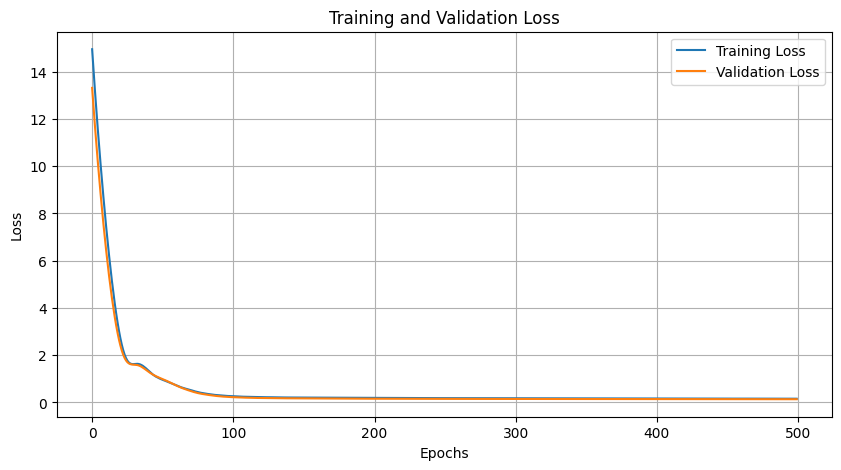

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


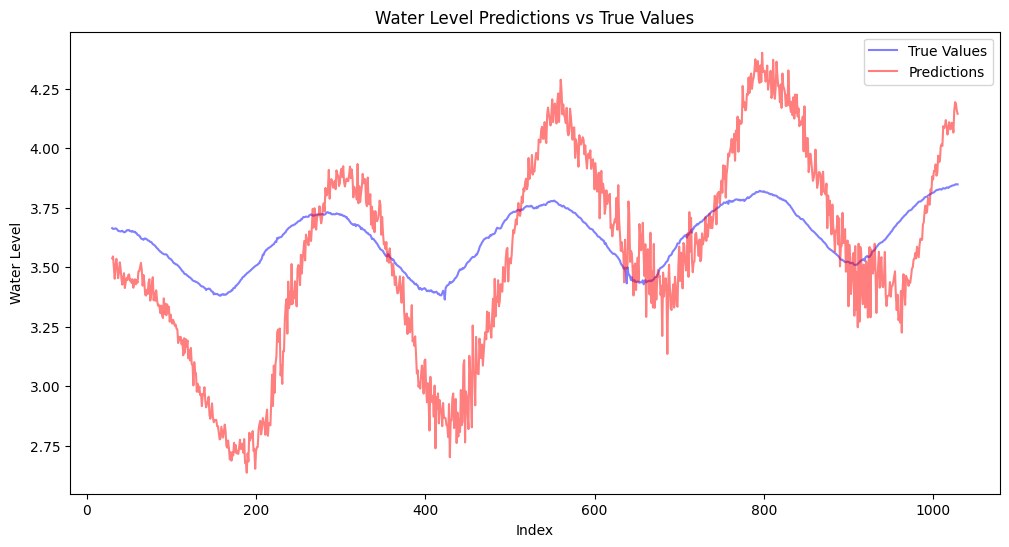

In [17]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=3, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=3, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=3, wind_window=3)

print(X_train.shape, y_train.shape)

model_file_name = '3wl_3uv.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.02),
    #tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

6hr WL 3hr UV

(161330, 181) (161330,)
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 14.9101 - mae: 3.8419
Epoch 1: val_loss improved from inf to 13.68848, saving model to 6wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 14.9101 - mae: 3.8419 - val_loss: 13.6885 - val_mae: 3.6766
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 14.0301 - mae: 3.7243
Epoch 2: val_loss improved from 13.68848 to 12.92326, saving model to 6wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 14.0301 - mae: 3.7243 - val_loss: 12.9233 - val_mae: 3.5688
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 13.1823 - mae: 3.6068
Epoch 3: val_loss improved from 12.92326 to 12.18881, saving model to 6wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 13.1823 - mae: 3.6068 - val_loss: 12.1888 - val_mae: 3.4615
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 12.3686 - mae: 3.4896
Epoch 4: val_loss improved from 12.18881 to 11.48276, saving model to 6wl_3uv.keras
1/1 ━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 20)             │         3,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,985 (42.91 KB)

 Trainable params: 3,661 (14.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,324 (28.61 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1146 - mae: 0.2713
Loss: [0.11462247371673584, 0.2712744176387787]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step

Central Frequency Percentage 15cm: 32.954863427968746

Central Frequency Percentage 5cm: 11.2335607740158

Central Frequency Percentage 1cm: 2.2331518112744573
Mean Squared Error: 0.11462247786394601
Root Mean Squared Error: 0.33855941555943475
Mean Absolute Error: 0.2712744289194687
Median Absolute Error: 0.2347676506042482
R-squared: -3.9888137788207043


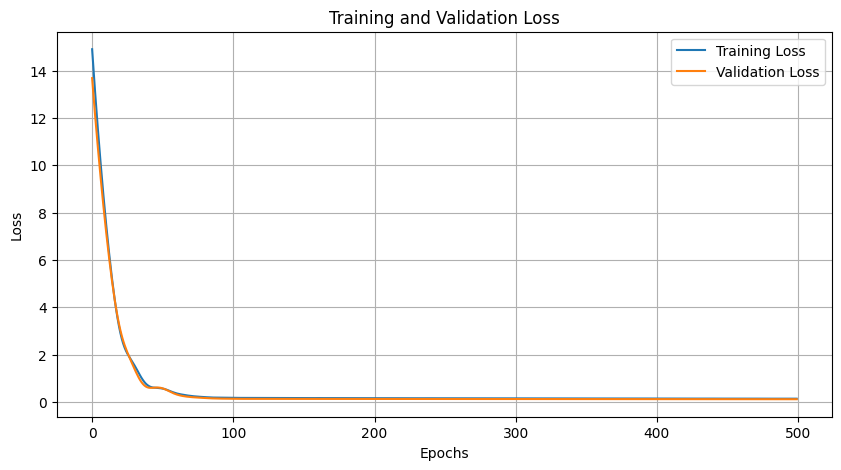

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


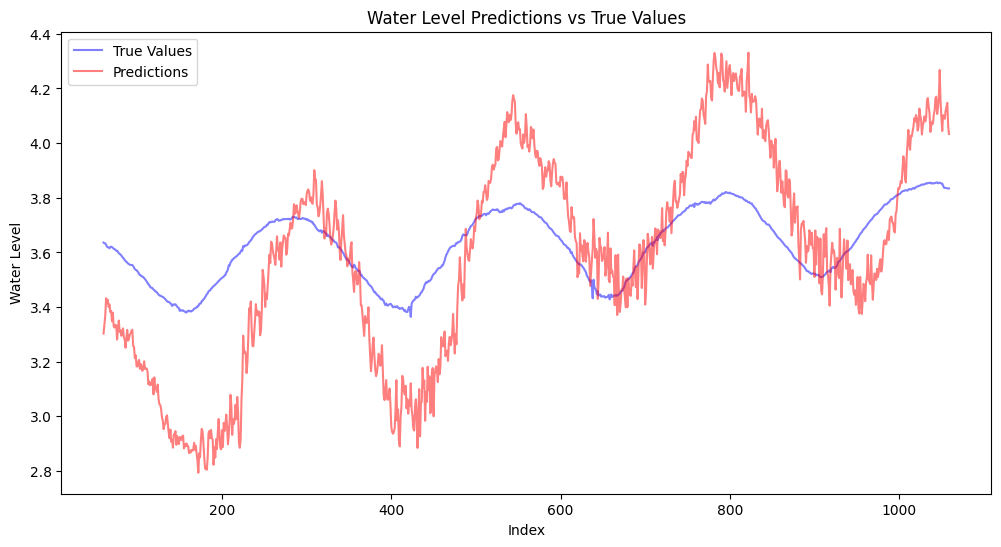

In [18]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=6, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=6, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=6, wind_window=3)

print(X_train.shape, y_train.shape)

model_file_name = '6wl_3uv.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.02),
    #tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

1hr WL 3hr UV

(165143, 81) (165143,)
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 19.3830 - mae: 4.3567
Epoch 1: val_loss improved from inf to 16.87393, saving model to 1wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 19.3830 - mae: 4.3567 - val_loss: 16.8739 - val_mae: 4.0753
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 18.2867 - mae: 4.2372
Epoch 2: val_loss improved from 16.87393 to 15.98266, saving model to 1wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 18.2867 - mae: 4.2372 - val_loss: 15.9827 - val_mae: 3.9706
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 17.2308 - mae: 4.1179
Epoch 3: val_loss improved from 15.98266 to 15.12934, saving model to 1wl_3uv.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 17.2308 - mae: 4.1179 - val_loss: 15.1293 - val_mae: 3.8670
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.2283 - mae: 4.0007
Epoch 4: val_loss improved from 15.12934 to 14.31146, saving model to 1wl_3uv.keras
1/1 ━━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 20)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,985 (19.48 KB)

 Trainable params: 1,661 (6.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,324 (12.99 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1404 - mae: 0.2969
Loss: [0.1403617262840271, 0.29692259430885315]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

Central Frequency Percentage 15cm: 31.449415207778852

Central Frequency Percentage 5cm: 10.825283382993838

Central Frequency Percentage 1cm: 2.1663291166085235
Mean Squared Error: 0.14036171870440456
Root Mean Squared Error: 0.3746487938114903
Mean Absolute Error: 0.2969225953166416
Median Absolute Error: 0.2502809200286866
R-squared: -5.126835154376381


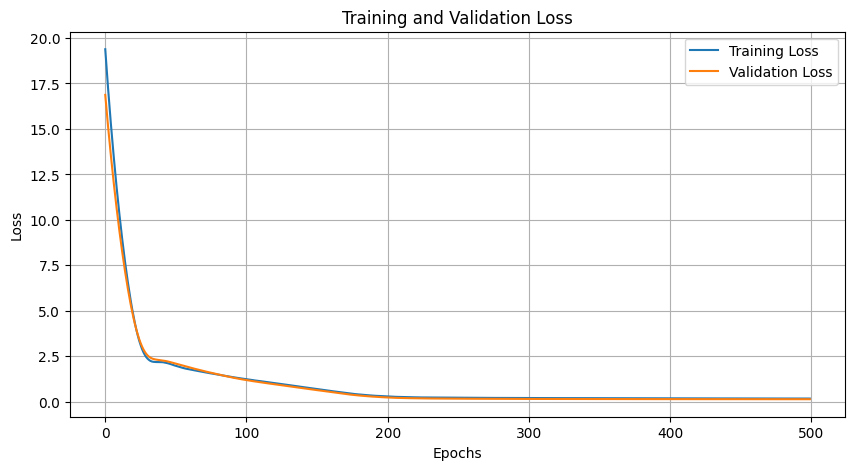

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


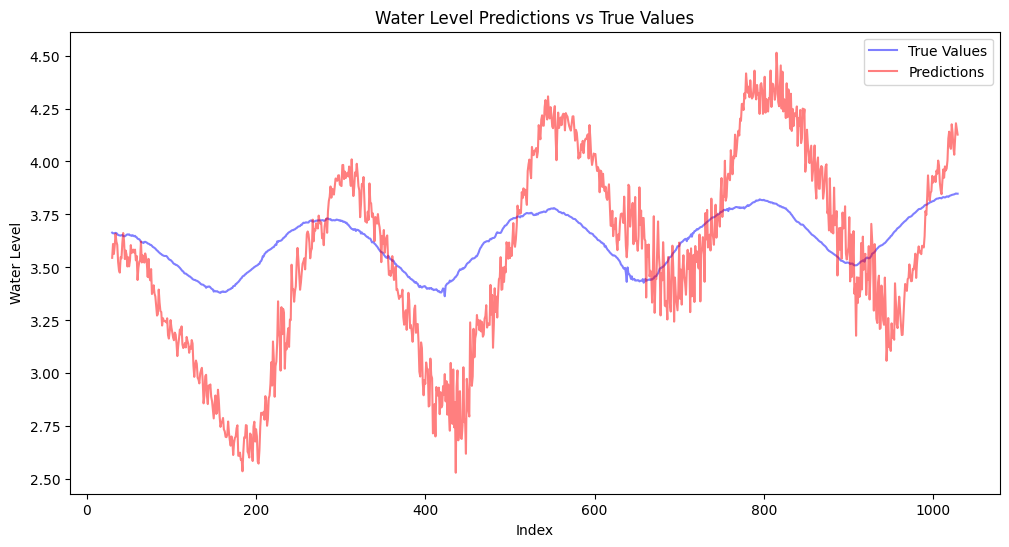

In [20]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=1, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=1, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=1, wind_window=3)

print(X_train.shape, y_train.shape)

model_file_name = '1wl_3uv.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.02),
    #tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

Changing model inputs and layers

3hr wl 3hr uv 40 0.001 20

(163997, 121) (163997,)
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12.4070 - mae: 3.5113
Epoch 1: val_loss improved from inf to 11.31566, saving model to 1wl_3uv_4020.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 12.4070 - mae: 3.5113 - val_loss: 11.3157 - val_mae: 3.3513
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 11.3093 - mae: 3.3505
Epoch 2: val_loss improved from 11.31566 to 10.30549, saving model to 1wl_3uv_4020.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 11.3093 - mae: 3.3505 - val_loss: 10.3055 - val_mae: 3.1950
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 10.2564 - mae: 3.1872
Epoch 3: val_loss improved from 10.30549 to 9.33888, saving model to 1wl_3uv_4020.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 10.2564 - mae: 3.1872 - val_loss: 9.3389 - val_mae: 3.0363
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 9.2488 - mae: 3.0211
Epoch 4: val_loss improved from 9.33888 to 8.41922, saving model to 1wl_3uv_4020.

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 40)             │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,165 (67.05 KB)

 Trainable params: 5,721 (22.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,444 (44.71 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1298 - mae: 0.2840
Loss: [0.129826620221138, 0.2840093672275543]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

Central Frequency Percentage 15cm: 32.870321054986256

Central Frequency Percentage 5cm: 11.22520718379173

Central Frequency Percentage 1cm: 2.1954025437269644
Mean Squared Error: 0.12982661574074822
Root Mean Squared Error: 0.3603146066158687
Mean Absolute Error: 0.28400937375839685
Median Absolute Error: 0.23870707798004154
R-squared: -4.660771966081547


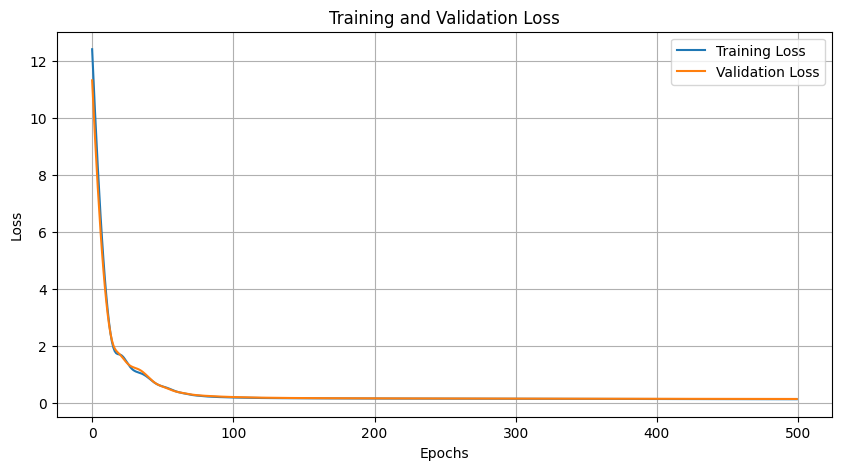

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


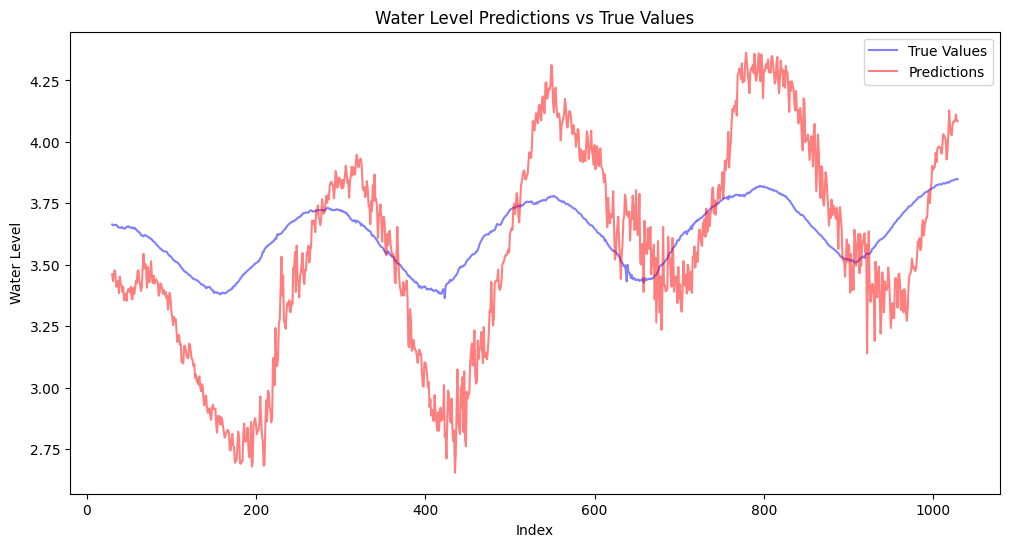

In [23]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=3, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=3, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=3, wind_window=3)

print(X_train.shape, y_train.shape)

model_file_name = '1wl_3uv_4020.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.001),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

3hr wl 1hr uv 20 0.001 20

(170239, 81) (170239,)
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 15.2089 - mae: 3.8922
Epoch 1: val_loss improved from inf to 14.21295, saving model to 3wl_1uv_2020.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 15.2089 - mae: 3.8922 - val_loss: 14.2130 - val_mae: 3.7626
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 14.6817 - mae: 3.8245
Epoch 2: val_loss improved from 14.21295 to 13.74314, saving model to 3wl_1uv_2020.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 14.6817 - mae: 3.8245 - val_loss: 13.7431 - val_mae: 3.7000
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 14.1808 - mae: 3.7588
Epoch 3: val_loss improved from 13.74314 to 13.29694, saving model to 3wl_1uv_2020.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 14.1808 - mae: 3.7588 - val_loss: 13.2969 - val_mae: 3.6395
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 13.7053 - mae: 3.6952
Epoch 4: val_loss improved from 13.29694 to 12.87469, saving model to 3wl_1uv

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 20)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,245 (24.40 KB)

 Trainable params: 2,081 (8.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,164 (16.27 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1214 - mae: 0.2756
Loss: [0.12137267738580704, 0.2756364345550537]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step

Central Frequency Percentage 15cm: 33.48133478140505

Central Frequency Percentage 5cm: 11.580314742647841

Central Frequency Percentage 1cm: 2.3776059967205434
Mean Squared Error: 0.12137266872180828
Root Mean Squared Error: 0.34838580442062833
Mean Absolute Error: 0.2756364256473002
Median Absolute Error: 0.23341893959045423
R-squared: -4.292929217729654


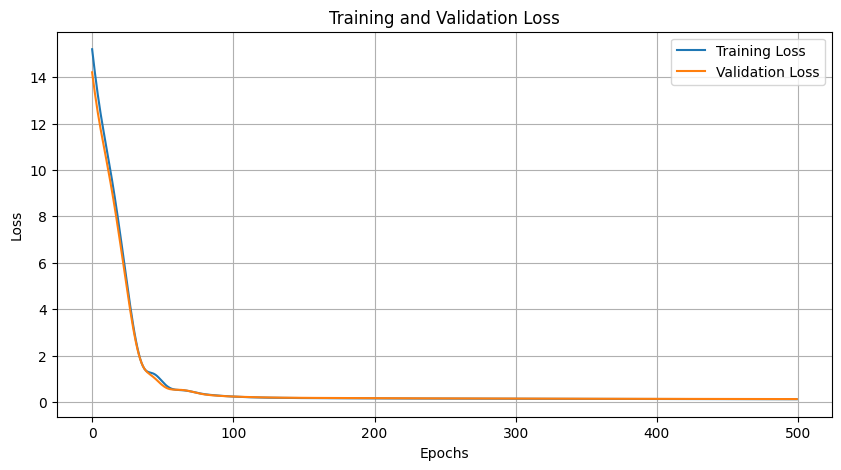

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


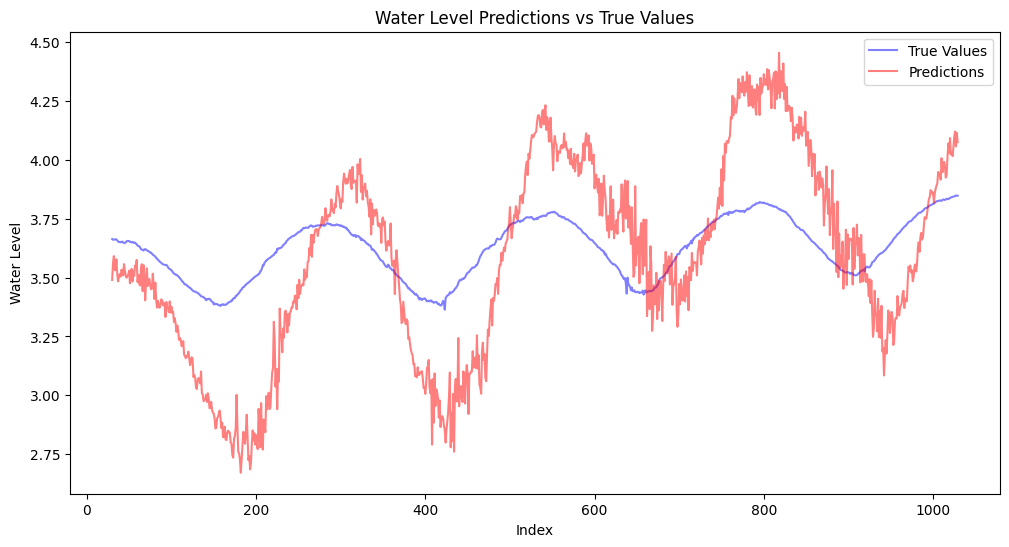

In [22]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=3, wind_window=1)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=3, wind_window=1)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=3, wind_window=1)

print(X_train.shape, y_train.shape)

model_file_name = '3wl_1uv_2020.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.001),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

3hr wl 3hr uv 

betos feature inputs are 4 inputs and 20 units on first layer 5x the amount of inputs

using that same idea for the first layer here 5*inputs = layer 1 units,  121*5  = 605 inputs

(163997, 121) (163997,)
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 10.8393 - mae: 3.2511
Epoch 1: val_loss improved from inf to 2.88578, saving model to 3wl_1uv_605.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 10.8393 - mae: 3.2511 - val_loss: 2.8858 - val_mae: 1.4544
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 3.0413 - mae: 1.4766
Epoch 2: val_loss did not improve from 2.88578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 3.0413 - mae: 1.4766 - val_loss: 4.2187 - val_mae: 1.6449
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 5.1032 - mae: 1.8177
Epoch 3: val_loss did not improve from 2.88578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 5.1032 - mae: 1.8177 - val_loss: 4.5191 - val_mae: 1.6404
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 4.3710 - mae: 1.6317
Epoch 4: val_loss did not improve from 2.88578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 4.3710 - mae: 1.6317 - val_loss: 3.8970 - val_mae: 1.3503
Epoch 5/500
1/1 ━━

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 605)            │        73,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 605)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,250 (872.07 KB)

 Trainable params: 74,416 (290.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 148,834 (581.39 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0476 - mae: 0.1637
Loss: [0.04761243239045143, 0.16368097066879272]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

Central Frequency Percentage 15cm: 55.99394959415412

Central Frequency Percentage 5cm: 20.041969364494346

Central Frequency Percentage 1cm: 4.143675834593834
Mean Squared Error: 0.04761243107560381
Root Mean Squared Error: 0.2182027293037459
Mean Absolute Error: 0.16368096547498678
Median Absolute Error: 0.13147035980224597
R-squared: -1.0760235759975498


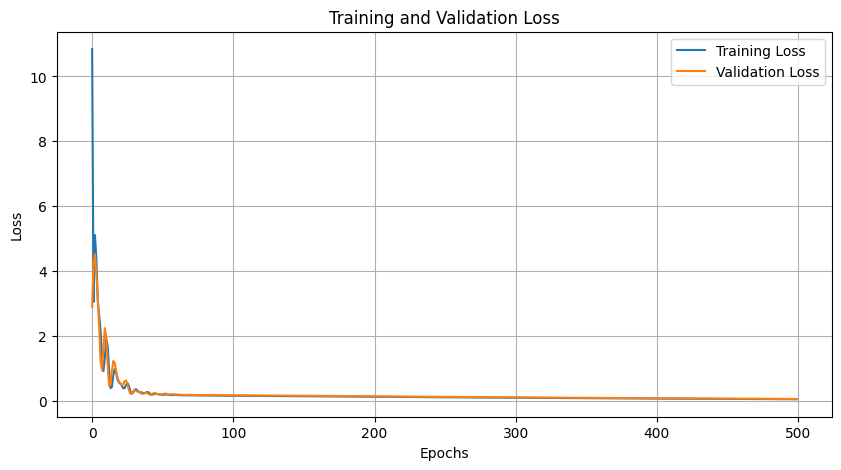

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


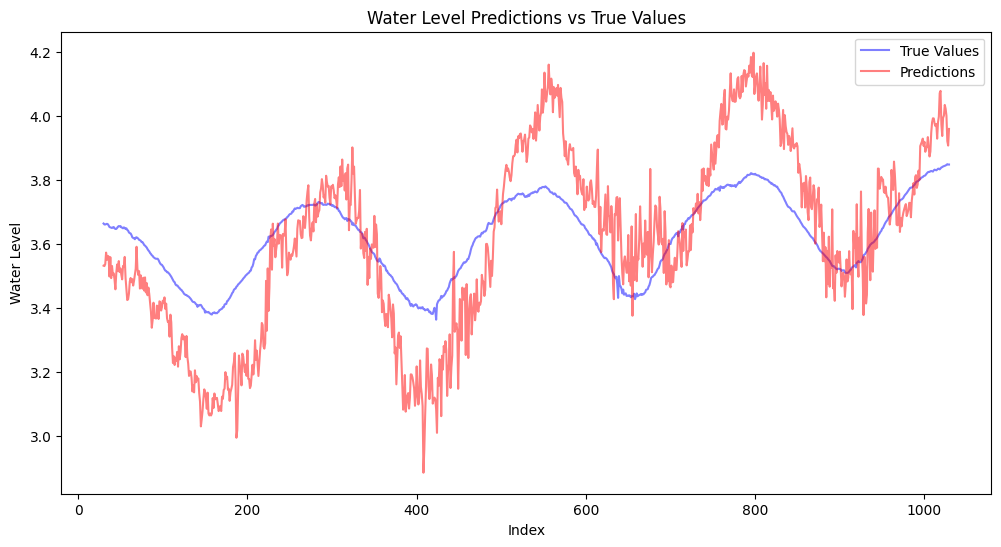

In [24]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=3, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=3, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=3, wind_window=3)

print(X_train.shape, y_train.shape)

model_file_name = '3wl_1uv_605.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(605, activation='relu'),
    tf.keras.layers.Dropout(0.001),
    #tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

two layers of 605

(163997, 121) (163997,)
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - loss: 17.8257 - mae: 4.1870
Epoch 1: val_loss improved from inf to 11.79670, saving model to 3wl_1uv_605605.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - loss: 17.8257 - mae: 4.1870 - val_loss: 11.7967 - val_mae: 2.7299
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 12.3735 - mae: 2.8102
Epoch 2: val_loss improved from 11.79670 to 8.82788, saving model to 3wl_1uv_605605.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 12.3735 - mae: 2.8102 - val_loss: 8.8279 - val_mae: 2.3954
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 8.9962 - mae: 2.4246
Epoch 3: val_loss improved from 8.82788 to 2.01944, saving model to 3wl_1uv_605605.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 8.9962 - mae: 2.4246 - val_loss: 2.0194 - val_mae: 1.1241
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 1.9068 - mae: 1.0853
Epoch 4: val_loss improved from 2.01944 to 1.55268, saving model to 3wl_1u

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 605)            │        73,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 605)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 605)            │       366,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,323,140 (5.05 MB)

 Trainable params: 441,046 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 882,094 (3.36 MB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0264 - mae: 0.1198
Loss: [0.026410333812236786, 0.11984044313430786]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step

Central Frequency Percentage 15cm: 71.42354971345789

Central Frequency Percentage 5cm: 27.80204094676069

Central Frequency Percentage 1cm: 5.695690151047104
Mean Squared Error: 0.026410335324569757
Root Mean Squared Error: 0.16251256974329634
Mean Absolute Error: 0.11984043083596455
Median Absolute Error: 0.09401796054840084
R-squared: -0.151558060472601


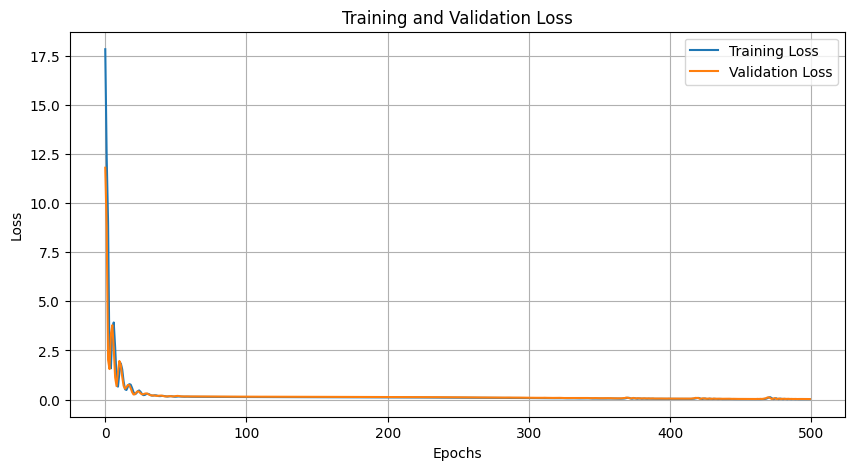

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


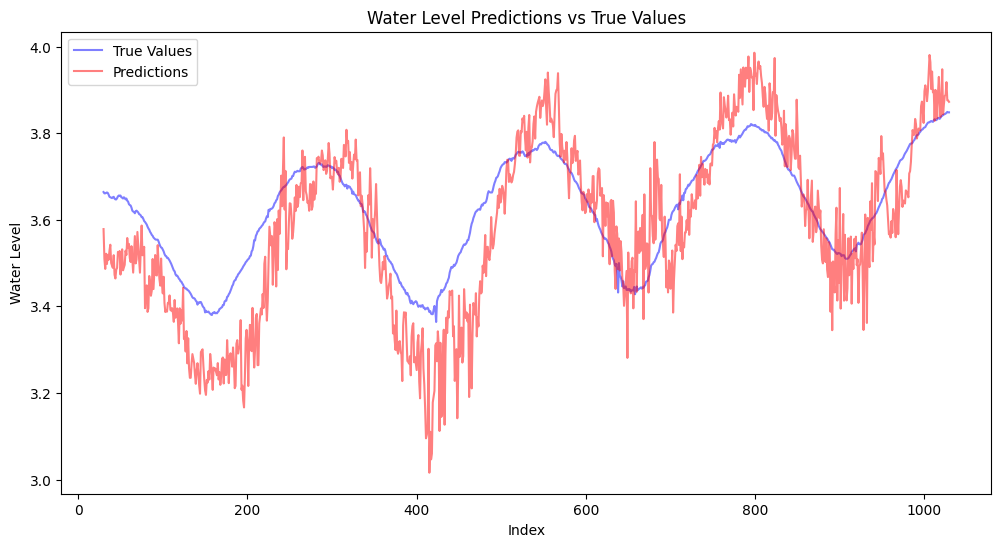

In [25]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=3, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=3, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=3, wind_window=3)

print(X_train.shape, y_train.shape)

model_file_name = '3wl_1uv_605605.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(605, activation='relu'),
    tf.keras.layers.Dropout(0.001),
    tf.keras.layers.Dense(605, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

(163997, 121) (163997,)


2025-05-28 10:47:33.917413: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-28 10:47:33.917539: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-28 10:47:33.917593: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-28 10:47:33.917725: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-28 10:47:33.917807: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

Epoch 1/500


I0000 00:00:1748447256.433767    6883 service.cc:146] XLA service 0x79fda8409250 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748447256.433814    6883 service.cc:154]   StreamExecutor device (0): Radeon RX 7900 GRE, AMDGPU ISA version: gfx1100
2025-05-28 10:47:36.466497: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 10.4572 - mae: 3.2165

I0000 00:00:1748447266.336107    6883 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 8.64820, saving model to 3wl_3uv_6060.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 10.4572 - mae: 3.2165 - val_loss: 8.6482 - val_mae: 2.9106
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 8.5764 - mae: 2.8998
Epoch 2: val_loss improved from 8.64820 to 6.99786, saving model to 3wl_3uv_6060.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 8.5764 - mae: 2.8998 - val_loss: 6.9979 - val_mae: 2.5928
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 6.8715 - mae: 2.5699
Epoch 3: val_loss improved from 6.99786 to 5.53689, saving model to 3wl_3uv_6060.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 6.8715 - mae: 2.5699 - val_loss: 5.5369 - val_mae: 2.2607
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.3566 - mae: 2.2230
Epoch 4: val_loss improved from 5.53689 to 4.27917, saving model to 3wl_3uv_6060.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 5.3566 - mae: 2.2230 - val_loss: 4.2792 - val_mae: 1.913

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,125 (129.40 KB)

 Trainable params: 11,041 (43.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,084 (86.27 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0975 - mae: 0.2412
Loss: [0.0975026860833168, 0.2411797046661377]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step

Central Frequency Percentage 15cm: 39.13803020942074

Central Frequency Percentage 5cm: 13.830716461790834

Central Frequency Percentage 1cm: 2.859029804640065
Mean Squared Error: 0.09750269079049143
Root Mean Squared Error: 0.3122542086033292
Mean Absolute Error: 0.24117971672895258
Median Absolute Error: 0.1979705333709718
R-squared: -3.251366297235273


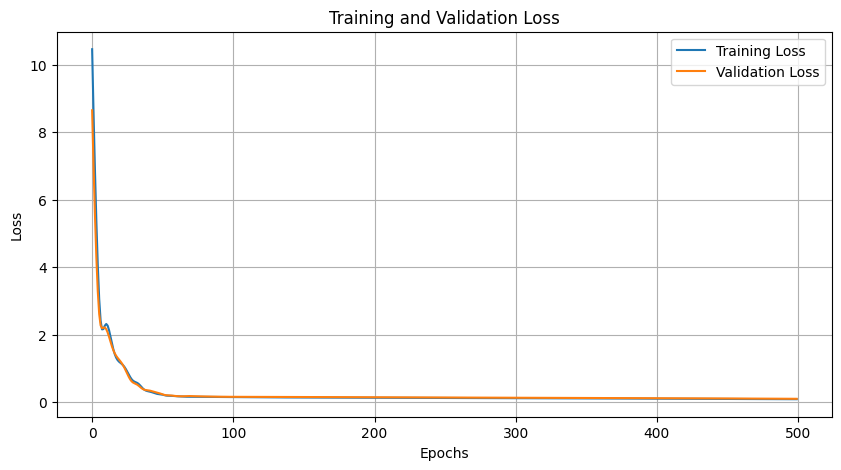

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


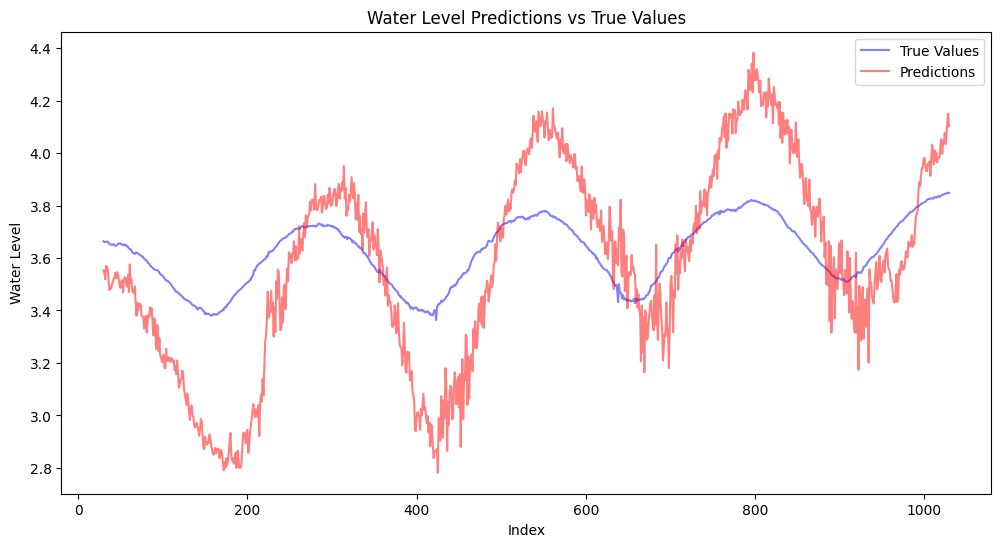

In [4]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=3, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=3, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=3, wind_window=3)

print(X_train.shape, y_train.shape)

model_file_name = '3wl_3uv_6060.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dropout(0.001),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 500
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

(163997, 121) (163997,)
Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 14.0311 - mae: 3.7106
Epoch 1: val_loss improved from inf to 10.89294, saving model to 3wl_3uv_6060.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 14.0311 - mae: 3.7106 - val_loss: 10.8929 - val_mae: 3.2710
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 10.9667 - mae: 3.2718
Epoch 2: val_loss improved from 10.89294 to 8.49562, saving model to 3wl_3uv_6060.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 10.9667 - mae: 3.2718 - val_loss: 8.4956 - val_mae: 2.8722
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 8.5352 - mae: 2.8636
Epoch 3: val_loss improved from 8.49562 to 6.50723, saving model to 3wl_3uv_6060.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 8.5352 - mae: 2.8636 - val_loss: 6.5072 - val_mae: 2.4806
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 6.5451 - mae: 2.4620
Epoch 4: val_loss improved from 6.50723 to 4.86786, saving model to 3wl_3uv_6060.k

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 170)            │        20,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 40)             │         6,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,865 (323.70 KB)

 Trainable params: 27,621 (107.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,244 (215.80 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0062 - mae: 0.0590
Loss: [0.006233822088688612, 0.058983687311410904]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step

Central Frequency Percentage 15cm: 95.00095869106713

Central Frequency Percentage 5cm: 51.91951255885298

Central Frequency Percentage 1cm: 10.727753041181106
Mean Squared Error: 0.006233822247548989
Root Mean Squared Error: 0.07895455811762225
Mean Absolute Error: 0.05898368966099696
Median Absolute Error: 0.047976061820983906
R-squared: 0.7281894315805924


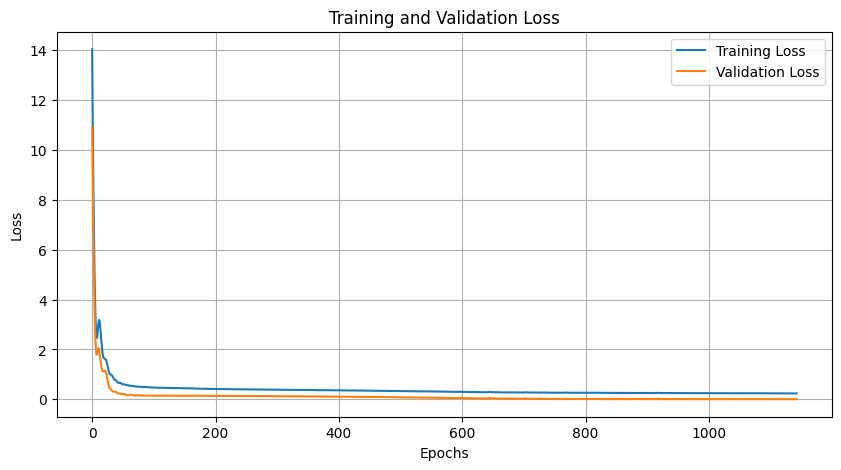

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


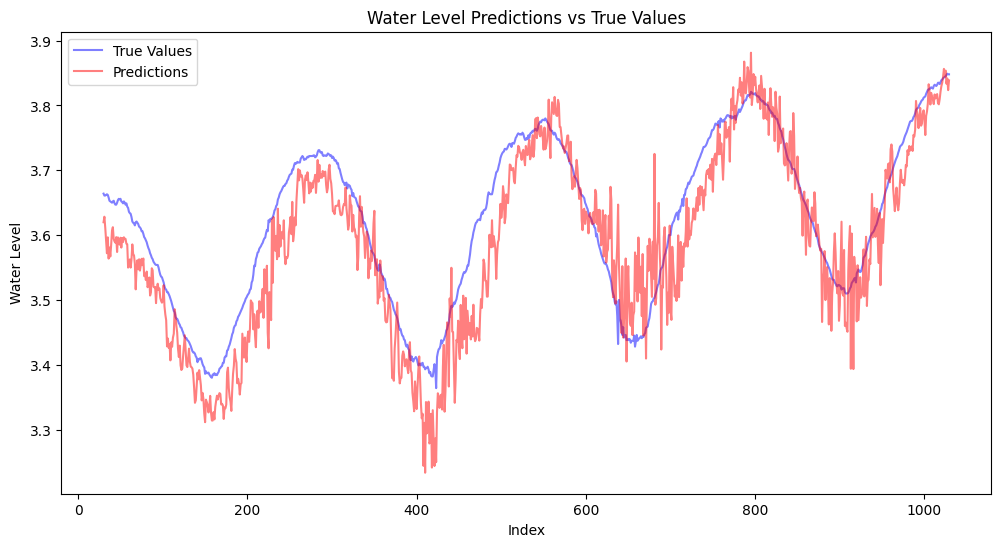

In [ ]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=3, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=3, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=3, wind_window=3)

print(X_train.shape, y_train.shape)

model_file_name = '3wl_3uv_6060.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(170, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 2000
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

evaluate_model(model, X_valid, y_valid)

#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()

In [11]:
timestamps = datasets['po13'].iloc[indices_valid]['date_time']

# Get predictions from best model
predictions = model.predict(X_valid, batch_size=len(X_valid))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


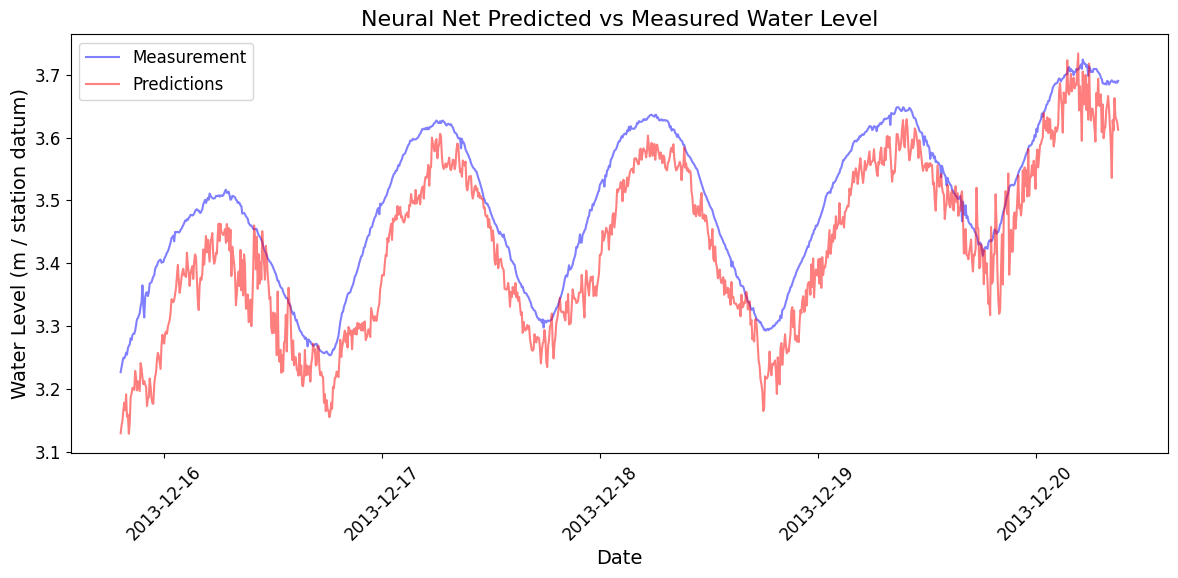

In [16]:
import matplotlib as mpl

# Set global font sizes
mpl.rcParams.update({
    'font.size': 14,         # Base font size
    'axes.titlesize': 16,    # Title font size
    'axes.labelsize': 14,    # Axis label font size
    'xtick.labelsize': 12,   # X tick labels
    'ytick.labelsize': 12,   # Y tick labels
    'legend.fontsize': 12    # Legend
})
# Plot
plt.figure(figsize=(12, 6))
plt.plot(timestamps[3400:4500], y_valid[3400:4500], label='Measurement', color='blue', alpha=0.5)
plt.plot(timestamps[3400:4500], predictions[3400:4500], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Water Level (m / station datum)')
plt.title('Neural Net Predicted vs Measured Water Level')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Neural net predicted waterlevel vs measured waterlevel
Water level (m / station datum)
Time Stamps
Date